# Introduction to Keras

https://www.datacamp.com/community/tutorials/deep-learning-python
https://keras.io/models/sequential/

In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [3]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


## Read in the dataset

In [4]:
# what's my current working directory?
home=Path.cwd()
home

PosixPath('/Users/austinlasseter/atelier/generalassembly/DATDC33/Lesson18_Neural_Nets_Intro/code')

In [5]:
# where is my data located?
datapath=Path.joinpath(home.parent, 'data')
print(datapath)

/Users/austinlasseter/atelier/generalassembly/DATDC33/Lesson18_Neural_Nets_Intro/data


In [6]:
# What files are located there?
os.listdir(datapath)

['abalone.csv', 'wines.pkl']

In [7]:
# read in the dataset. 'Pickle' is a standard file format for saving python objects.
wines = pd.read_pickle('../data/wines.pkl')
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


## Exploratory Data Analysis

In [8]:
# Any missing data?
wines.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

In [9]:
# is the target imbalanced?
wines['type'].value_counts() # Note: 0 = white, 1 = red.

0    4898
1    1599
Name: type, dtype: int64

In [10]:
# which variables are most associated with the target?
corrs = wines.corr()
corrs['type'].sort_values()

total sulfur dioxide   -0.700357
free sulfur dioxide    -0.471644
residual sugar         -0.348821
citric acid            -0.187397
quality                -0.119323
alcohol                -0.032970
pH                      0.329129
density                 0.390645
fixed acidity           0.486740
sulphates               0.487218
chlorides               0.512678
volatile acidity        0.653036
type                    1.000000
Name: type, dtype: float64

## visualize relationships between key variables 
https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/

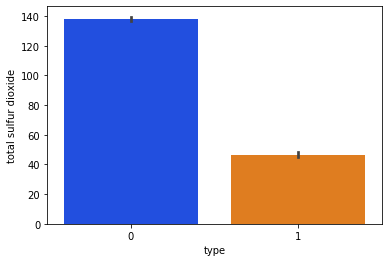

In [11]:
# white wines have more total sulfur dioxide
sns.barplot(x='type', y='total sulfur dioxide', data=wines, palette='bright');

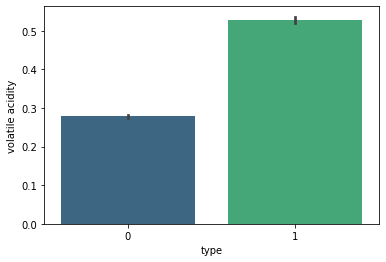

In [12]:
# red wines have higher acidity
sns.barplot(x='type', y='volatile acidity', data=wines, palette='viridis');

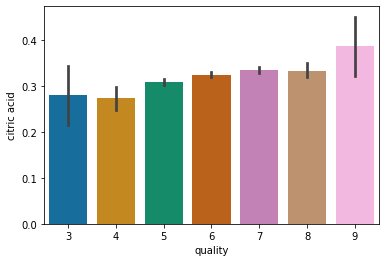

In [13]:
# On average, high quality wines also have higher citric acid.
sns.barplot(x='quality', y='citric acid',  data=wines, palette='colorblind');

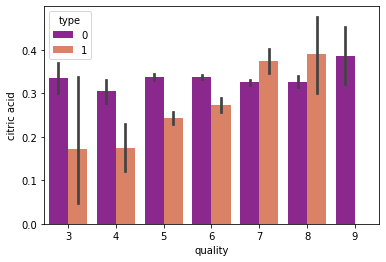

In [14]:
# Does that relationship vary for red and white wines? Yes, it does. 
# High-quality red wines have more citric acid than low-quality red wines, but this isn't true for whites.
sns.barplot(x='quality', y='citric acid', hue='type', data=wines, palette='plasma');

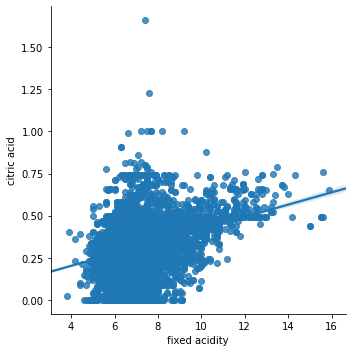

In [15]:
# Higher citric acid is associated with higher fixed acidity.
sns.lmplot(x='fixed acidity', y='citric acid', data=wines, palette='Blues');

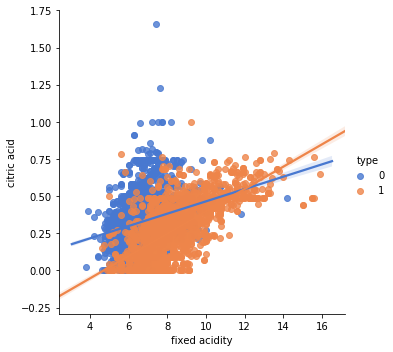

In [16]:
# But the relationship between them varies for red and white wines.
sns.lmplot(x='fixed acidity', y='citric acid', hue='type', data=wines, palette='muted');

## Feature Engineering

In [17]:
# List all the columns in the dataset.
wines.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'type'],
      dtype='object')

In [18]:
# Make a list of the features. Notice that we left out "quality" and "type" on purpose.
feature_vars=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 
              'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

In [19]:
# Establish X as your feature variables.
X=wines[feature_vars]

In [20]:
# Remember that you can also do this by simply dropping the vars you don't want to keep.
X=wines.drop(['quality','type'], axis=1)

Our features are numeric but have very different metrics. Let's scale (i.e., "standardize") them so they can be compared.

In [21]:
# Instantiate the sklearn class.
scaler = StandardScaler()

In [22]:
# Fit the scaler to your feature variables. It's not necessary to scale the target.
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
# Scale the features so that they each have a mean of 0 and a standard deviation of 1.
X_scaled = scaler.transform(X)

In [24]:
# Notice that this transforms our dataframe into a numpy array. Here's the first row - before and after scaling.
# Why does each array have exactly 11 values?
print('Before scaling:',[round (i,2) for i in list(X.loc[0].values)])
print('After scaling:',[round(i,2) for i in X_scaled[0]])

Before scaling: [7.4, 0.7, 0.0, 1.9, 0.08, 11.0, 34.0, 1.0, 3.51, 0.56, 9.4]
After scaling: [0.14, 2.19, -2.19, -0.74, 0.57, -1.1, -1.45, 1.03, 1.81, 0.19, -0.92]


## Modeling, Part 1: Regression
Can we predict the quality of the wine, based on its features?

#### Split the data

In [25]:
# Establish y as your target variable.
y=wines['quality']

In [26]:
# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

#### Specify the architecture of your model

In [27]:
# Initialize the constructor
model = Sequential()

W0627 19:24:13.041637 140735746605952 deprecation_wrapper.py:119] From /Users/austinlasseter/anaconda3/envs/keras-env2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [28]:
# Add an input layer 
model.add(Dense(64, input_dim=11, activation='relu'))

W0627 19:24:13.094939 140735746605952 deprecation_wrapper.py:119] From /Users/austinlasseter/anaconda3/envs/keras-env2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 19:24:13.119688 140735746605952 deprecation_wrapper.py:119] From /Users/austinlasseter/anaconda3/envs/keras-env2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [29]:
# Add an output layer 
model.add(Dense(1))

In [30]:
# Print a summary of the model you've built.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                768       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


#### Model compilation

In [31]:
# Choose the loss function, optimizer, and evaluation metric for your model. 
model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics=['mae'])

W0627 19:24:13.181135 140735746605952 deprecation_wrapper.py:119] From /Users/austinlasseter/anaconda3/envs/keras-env2/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



#### Fit and Predict

In [32]:
# fit the model to the training data                  
model.fit(X_train, y_train, epochs=10, verbose=1)

W0627 19:24:13.314394 140735746605952 deprecation_wrapper.py:119] From /Users/austinlasseter/anaconda3/envs/keras-env2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0627 19:24:13.319383 140735746605952 deprecation_wrapper.py:119] From /Users/austinlasseter/anaconda3/envs/keras-env2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/10
4352/4352 [==============================] - 0s 115us/step - loss: 13.9705 - mean_absolute_error: 3.3877
Epoch 2/10
4352/4352 [==============================] - 0s 18us/step - loss: 2.0549 - mean_absolute_error: 1.1237
Epoch 3/10
4352/4352 [==============================] - 0s 19us/step - loss: 1.3022 - mean_absolute_error: 0.8879
Epoch 4/10
4352/4352 [==============================] - 0s 19us/step - loss: 0.9880 - mean_absolute_error: 0.7731
Epoch 5/10
4352/4352 [==============================] - 0s 19us/step - loss: 0.7997 - mean_absolute_error: 0.6918
Epoch 6/10
4352/4352 [==============================] - 0s 19us/step - loss: 0.6817 - mean_absolute_error: 0.6377
Epoch 7/10
4352/4352 [==============================] - 0s 19us/step - loss: 0.6185 - mean_absolute_error: 0.6043
Epoch 8/10
4352/4352 [==============================] - 0s 19us/step - loss: 0.5781 - mean_absolute_error: 0.5852
Epoch 9/10
4352/4352 [==============================] - 0s 19us/step - loss: 0.5522 - 

In [33]:
# predict on the testing data
y_pred = model.predict(X_test)

In [34]:
# Compare the first 5 values
print('preds:', [round(x[0]) for x in y_pred[:5]])
print('true values:', [x for x in y_test[:5]])

preds: [7.0, 5.0, 6.0, 6.0, 6.0]
true values: [8, 5, 7, 6, 6]


#### Evaluate the performance of your model

In [35]:
# Calculate root mean squared error. By how much does our model err, on average?
from math import sqrt
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))
rmse

0.745385392380795

In [36]:
# R-squared calculates the amount of variance in the outcome explained by the model.
r2 = metrics.r2_score(y_test, y_pred)
round(r2,4)

0.2485

In [37]:
# Convert the numpy array of lists into a single list.
y_preds=[]
for x in y_pred.tolist():
    y_preds.append(x[0])

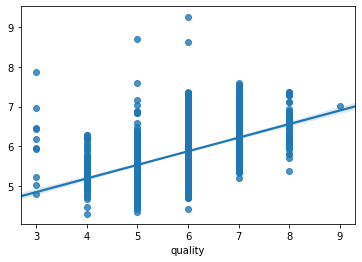

In [38]:
# Scatter plot to compare predictions vs. true values
sns.regplot(y_test, y_preds);

## Modeling, Part 2: Classification
Can we predict if it's red or white wine, based on its features?

#### Split the data

In [39]:
# Establish y as your target variable.
y=wines['type']

In [40]:
# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

#### Specify the architecture of your model

In [41]:
# Initialize the constructor
model = Sequential()

In [42]:
# Add an input layer 
model.add(Dense(12, activation='relu', input_shape=(11,)))

In [43]:
# Add one hidden layer 
model.add(Dense(8, activation='relu'))

In [44]:
# Add an output layer 
model.add(Dense(1, activation='sigmoid'))

In [45]:
# Print a summary of the model you've built.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                144       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


#### Model compilation

In [46]:
# Choose the loss function, optimizer, and evaluation metric for your model. 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

W0627 19:24:15.132808 140735746605952 deprecation.py:323] From /Users/austinlasseter/anaconda3/envs/keras-env2/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Fit and Predict

In [47]:
# fit the model to the training data                  
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
4352/4352 [==============================] - 3s 763us/step - loss: 0.0904 - acc: 0.9678
Epoch 2/20
4352/4352 [==============================] - 3s 702us/step - loss: 0.0273 - acc: 0.9943
Epoch 3/20
4352/4352 [==============================] - 3s 705us/step - loss: 0.0215 - acc: 0.9959
Epoch 4/20
4352/4352 [==============================] - 3s 704us/step - loss: 0.0185 - acc: 0.9963
Epoch 5/20
4352/4352 [==============================] - 3s 691us/step - loss: 0.0164 - acc: 0.9968
Epoch 6/20
4352/4352 [==============================] - 3s 691us/step - loss: 0.0145 - acc: 0.9963
Epoch 7/20
4352/4352 [==============================] - 3s 693us/step - loss: 0.0143 - acc: 0.9972
Epoch 8/20
4352/4352 [==============================] - 3s 700us/step - loss: 0.0139 - acc: 0.9966
Epoch 9/20
4352/4352 [==============================] - 3s 698us/step - loss: 0.0131 - acc: 0.9970
Epoch 10/20
4352/4352 [==============================] - 3s 691us/step - loss: 0.0150 - acc: 0.9970
Epoch 11/

In [48]:
# predict on the testing data
y_pred = model.predict(X_test)

In [49]:
# Compare the first 5 values
print('preds:', [round(x[0]) for x in y_pred[:5]])
print('true values:', [x for x in y_test[:5]])

preds: [0.0, 1.0, 0.0, 0.0, 0.0]
true values: [0, 1, 0, 0, 0]


#### Evaluate the performance of your model

In [50]:
# Evaluate the model accuracy
metrics.accuracy_score(y_test, y_pred.round())

0.9944055944055944

In [51]:
# Confusion matrix
metrics.confusion_matrix(y_test, y_pred.round())

array([[1585,    3],
       [   9,  548]])

In [52]:
# ROC-AUC score
metrics.roc_auc_score(y_test, y_pred.round())

0.9909764210031249

In [53]:
probs= model.predict_proba(X_test)
probs

array([[1.0506374e-01],
       [9.9847567e-01],
       [1.5658140e-04],
       ...,
       [8.2282126e-03],
       [4.0918589e-04],
       [7.8432509e-05]], dtype=float32)

In [54]:
# Convert the numpy array of lists into a single list.
y_probs=[]
for x in probs.tolist():
    y_probs.append(x[0])

In [55]:
# calculate false positive rate and true positive rate at various thresholds.
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)

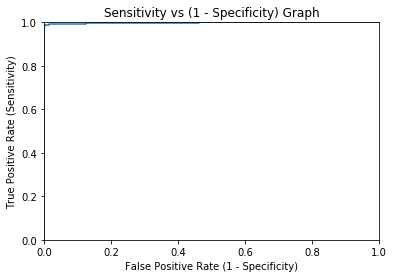

In [56]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Sensitivity vs (1 - Specificity) Graph')
plt.show()
# The curve is so high it's barely visible.